In [164]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
# Read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
# Build char vocab and mappings back and forth
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# Build dataset

block_size = 3 # Context length: how many characters do we take when we make a prediction
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

### Embedding Representation
* The paper represents 17,000 tokens in a 30 dimensional space
* We can represent our 27 tokens in a simple 2 dimensional space

In [14]:
C = torch.randn((27,2))

In [15]:
C[5]

tensor([ 1.7725, -0.4235])

In [20]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # We're not doing this. The results are the same, so we will directly use embedding tables

tensor([ 1.7725, -0.4235])

In [22]:
C[[5,6,7]], C[torch.tensor([5,6,7,7,7,7])]

(tensor([[ 1.7725, -0.4235],
         [ 0.5952, -0.8156],
         [-0.7062, -1.4913]]),
 tensor([[ 1.7725, -0.4235],
         [ 0.5952, -0.8156],
         [-0.7062, -1.4913],
         [-0.7062, -1.4913],
         [-0.7062, -1.4913],
         [-0.7062, -1.4913]]))

In [33]:
X[4]

tensor([13, 13,  1])

In [34]:
C[X].shape


torch.Size([32, 3, 2])

* `C[X]` is (32,3,2)
* 32 records or character blocks
* Each record has 3 char
* And this 3 char group will be embedded into 2 dimensions

In [26]:
X[13,2]

tensor(1)

In [27]:
C[X][13,2]

tensor([0.8851, 0.0354])

In [29]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [48]:
W1 = torch.randn((6,100)) # Input is 3 * 2 so 6, by # of neurons which is our choice
b1 = torch.rand(100)

In [36]:
emb[0,:, :]

tensor([[ 2.7886, -0.3674],
        [ 2.7886, -0.3674],
        [ 2.7886, -0.3674]])

### Reallign tensor dimensions
Many different ways

In [40]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[0]

tensor([ 2.7886, -0.3674,  2.7886, -0.3674,  2.7886, -0.3674])

In [44]:
torch.cat(torch.unbind(emb, 1), 1).shape
torch.cat(torch.unbind(emb, 1), 1)[0]

tensor([ 2.7886, -0.3674,  2.7886, -0.3674,  2.7886, -0.3674])

In [46]:
# view is most efficient for a lot of different internal pytorch reasons
emb.view(32,6)[0]

tensor([ 2.7886, -0.3674,  2.7886, -0.3674,  2.7886, -0.3674])

In [49]:
# The hidden layer
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [50]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [51]:
logits = h @ W2 + b2

In [52]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [58]:
torch.arange(32), Y

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [59]:
prob[torch.arange(32), Y] # The probabilities as assigned by the model currently for the correct characters in the sequence

tensor([8.7270e-01, 1.5088e-12, 2.5686e-10, 3.8136e-10, 2.4490e-07, 1.2634e-01,
        4.8381e-05, 1.7174e-11, 1.1674e-07, 5.9285e-11, 2.6164e-06, 8.5444e-08,
        1.7548e-11, 1.5215e-14, 1.2737e-14, 3.2251e-05, 1.5072e-11, 1.7932e-14,
        1.0816e-12, 9.7859e-09, 1.2228e-06, 9.0380e-08, 7.7217e-09, 7.7078e-05,
        9.7931e-01, 6.0797e-12, 7.9382e-05, 1.4865e-08, 2.7042e-09, 3.7597e-14,
        1.2666e-02, 1.7572e-02])

In [61]:
loss = -prob[torch.arange(32), Y].log().mean() # nll
loss

tensor(17.6129)

### Embeddings: All put together

#### Efficiency
* Find the right learning rate. You can do this establishing a learning rate space and goign over as a test
* Use minibatching
* LR decay

### Data Splitting
* Split to avoid overfitting into train, val/dev, test
* Train: 80%, used to get model params
* Val: 10%, help on train and get correct hyperparams
* Test: Evaluated sparingly to get clear model performance

In [233]:
# Build dataset
def build_dataset(words, block_size=3):
    # block_size = 3 # Context length: how many characters do we take when we make a prediction
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [234]:
# Data split
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
block_size = 5

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182437, 5]) torch.Size([182437])
torch.Size([22781, 5]) torch.Size([22781])
torch.Size([22928, 5]) torch.Size([22928])


In [235]:
Xtr.shape, Ytr.shape

(torch.Size([182437, 5]), torch.Size([182437]))

In [238]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((50,256), generator=g)
b1 = torch.randn((256), generator=g)
W2 = torch.randn((256, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [239]:
sum(p.nelement() for p in parameters) # total params

20265

Takes a long time on the full data, so we probably want to batch this

As the model get's bigger, it may take longer to converge. Maybe the batch size is too small. Maybe the bottleneck to network performance might be the embeddings are too small.


In [240]:
# Learning rate space to find optimal learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [241]:
lri = []
lossi = []
stepi = []

In [242]:
for p in parameters:
    p.requires_grad = True

for i in range(200000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, emb.shape[-1] * emb.shape[-2]) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean() # Inefficient
    loss = F.cross_entropy(logits, Ytr[ix]) # Much more efficient calculation and backward pass
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.5347213745117188


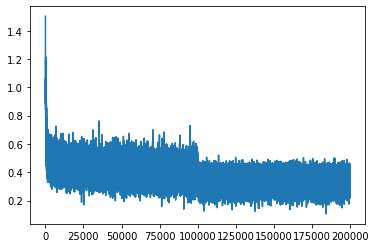

In [243]:
plt.plot(stepi, lossi)

**3 block:**
* 2.1495 on val

**5 block**
* 2.2168

In [244]:
# Check loss on validation entire data
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb.shape[-1] * emb.shape[-2]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # Much more efficient calculation and backward pass
print(loss)

tensor(2.2168, grad_fn=<NllLossBackward>)


In [245]:
# Check loss on training entire data
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb.shape[-1] * emb.shape[-2]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) # Much more efficient calculation and backward pass
print(loss)

tensor(2.1830, grad_fn=<NllLossBackward>)


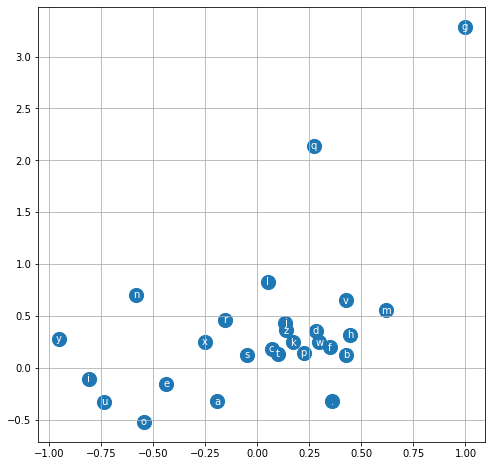

In [201]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

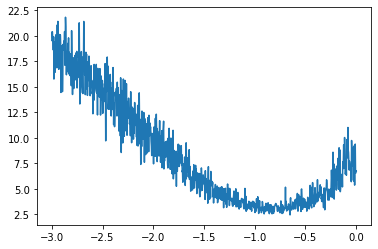

In [144]:
plt.plot(lri, lossi);

In [87]:
torch.randint(0, X.shape[0], (32,))

tensor([  6753, 152848, 155447, 224986,  99392, 199908,  98785,  88567, 106026,
        120385, 192629,  63509,  19114, 144453,  87560,  26129,   2200, 134368,
         39958,   8779,  79432,  62705, 149931, 175417, 194120, 144265,  47061,
        120117, 122267, 182998, 176140, 193350])

In [231]:
# Sampling from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amillivi.
kimish.
taty.
skanden.
jazonte.
deliah.
jareen.
ner.
kiah.
maiif.
kaleigh.
ham.
pory.
quinn.
sulie.
alianni.
watell.
dearisi.
fine.
